In [30]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [49]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [51]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [52]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect= True)

C:\Users\vjmar\AppData\Local\Temp\ipykernel_22380\3700933602.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect= True)


In [53]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [54]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [55]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [56]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
print(f"The most recent date in the data set is: {most_recent_date}")

The most recent date in the data set is: 2017-08-23


The date one year ago from the most recent date is: 2016-08-23


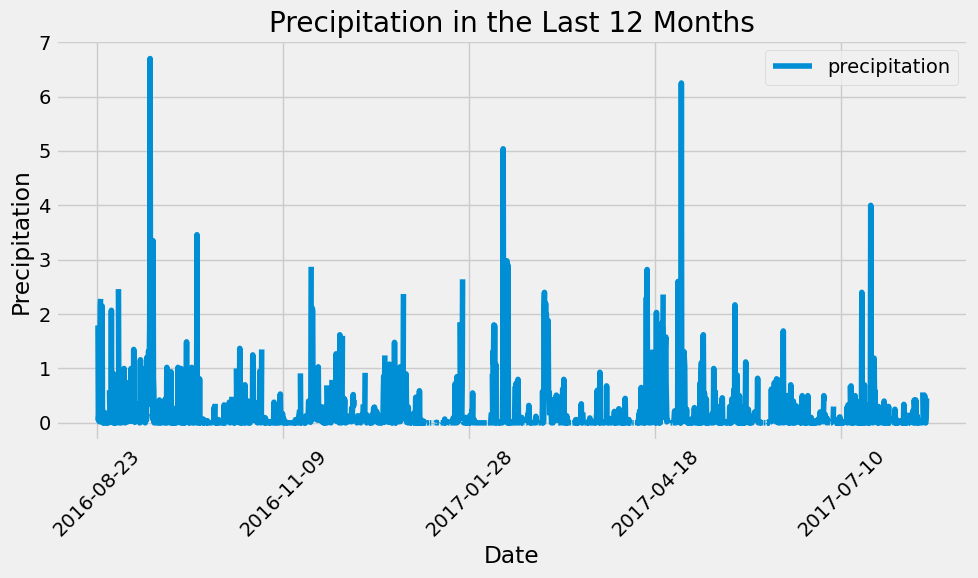

In [60]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = datetime.strptime(most_recent_date, "%Y-%m-%d").date() - timedelta(days=365)
print(f"The date one year ago from the most recent date is: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results_df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
results_df = results_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
results_df.plot(x='date', y='precipitation', kind='line', figsize=(10, 6), title='Precipitation in the Last 12 Months', xlabel='Date', ylabel='Precipitation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
# Use Pandas to calculate the summary statistics for the precipitation data
results_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [63]:
# Design a query to calculate the total number of stations in the dataset
total_stations= session.query(station.station).count()
total_stations

9

In [65]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity= session.query(measurement.station,func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).all() 
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [67]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).\
    first()

# Extract the station id
most_active_station_id = most_active_station[0]
print(f"The most active station ID is: {most_active_station_id}")

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id).all()

# Extract the results
lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
avg_temp = temperature_stats[0][2]

print(f"The lowest temperature for the most active station is: {lowest_temp}")
print(f"The highest temperature for the most active station is: {highest_temp}")
print(f"The average temperature for the most active station is: {avg_temp}")


The most active station ID is: USC00519281
The lowest temperature for the most active station is: 54.0
The highest temperature for the most active station is: 85.0
The average temperature for the most active station is: 71.66378066378067


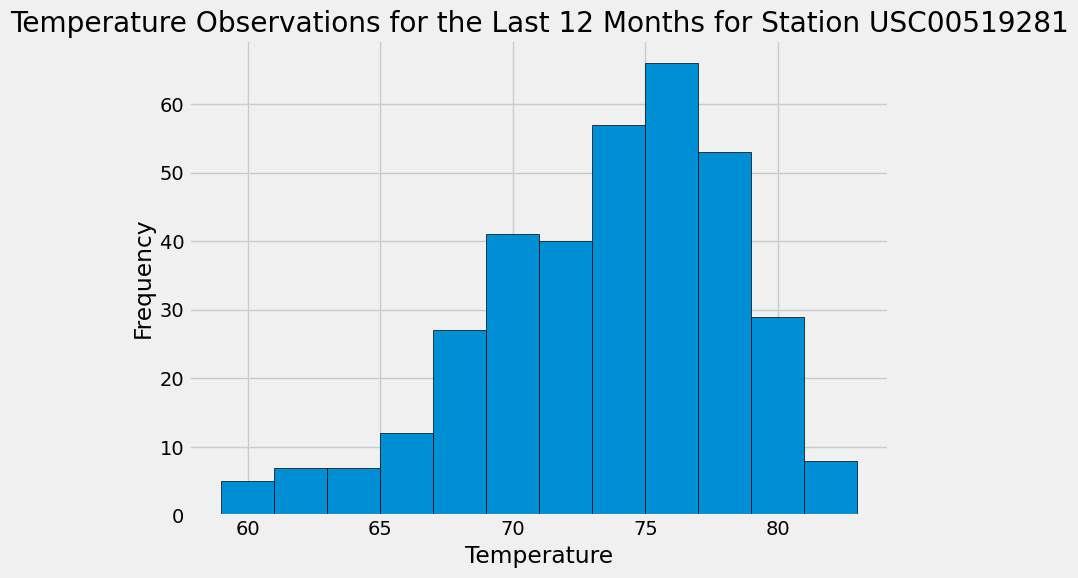

In [69]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['temperature'], bins=12, edgecolor='black')
plt.title('Temperature Observations for the Last 12 Months for Station ' + most_active_station_id)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [70]:
# Close Session
session.close()